# Introduction

This exercise solution is built on top of [this blog post by Hashir Ahmad](https://hash-ir.github.io/2020/05/17/bike-sharing-patterns/). This exercise will provide a step by step guide to building a multilayer perceptron to predict the count of rental bike usage given various features.


The python packages we will be using are:

[NumPy](https://numpy.org/): Powerful tool to work with N-dimensional arrays
 
[Pandas](https://pandas.pydata.org/): Data analysis and manipulation tool

[Matplotlib](https://matplotlib.org/): Visualization tool

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

Real data is always dirty! Before we can do any machine learning, we need to process the data so that it is in good shape for training our model. 

## Raw Data
Lets take a look at the data we will be working with, it is taken from the [University of California Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#), it contains the count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. Each data entry contains information for one hour of data and there are 17379 entries in total. 



In [10]:
# read the raw data into a pandas dataframe
data_path = "https://raw.githubusercontent.com/xuwil/99-ML-Learning-Projects/development/011/data/"

raw_df = pd.read_csv(data_path + 'hour.csv')

# take a look at the shape of our raw data, there are 17379 entries and each entry contains 17 fields
raw_df.shape

(17379, 17)

In [11]:
raw_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



It has the following fields:
```
instant: record index
dteday : date
season : season (1:winter, 2:spring, 3:summer, 4:fall)
yr : year (0: 2011, 1:2012)
mnth : month ( 1 to 12)
hr : hour (0 to 23)
holiday : weather day is holiday or not
weekday : day of the week (0 to 6)
workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
hum: Normalized humidity. The values are divided to 100 (max)
windspeed: Normalized wind speed. The values are divided to 67 (max)
casual: count of casual users
registered: count of registered users
cnt: count of total rental bikes including both casual and registered
```
Our goal is to predict the count of bike rentals (ie. casual, registered, cnt) given the other fields (features). 

## Unused Features

Is every feature useful in making this prediction? Consider:

**instant:** the record index does not provide any useful information about the count of bike rentals

**dteday:** the date does not contribute to the count of bike rentals, the information it offers is captured in the other features (if the date is a holiday,if the date is a weekday or a weekend)

**atemp:** the information this field offers is captured in the `temp` feature.

**workingday:** the information this field offers is captured int the `weekday` and `holiday` features.

Since these features offers no information (or duplicate information) for predicting the count of bike rentals, we first want to clean up the data by removing them.

In [ ]:
unused_features = ['instant', 'dteday', 'atemp', 'workingday']
processed_df = raw_df.drop(unused_features, axis=1)  # drop the unused features
processed_df.head()

,season,yr,mnth,hr,holiday,weekday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,1,0.24,0.81,0.0,3.0,13.0,16.0
1,1,0,1,1,0,6,1,0.22,0.80,0.0,8.0,32.0,40.0
2,1,0,1,2,0,6,1,0.22,0.80,0.0,5.0,27.0,32.0
3,1,0,1,3,0,6,1,0.24,0.75,0.0,3.0,10.0,13.0
4,1,0,1,4,0,6,1,0.24,0.75,0.0,0.0,1.0,1.0


## Categorical Features
Is the data ready to be used now? 

Consider the feature `mnth` which has values from 1 - 12 representing Janurary to December. The integer values have a natural ordered relationship between each other. However, should Feburary be ranked higher than January?  

No, no such ordinal relationship exists between each month. Therefore,
we cannot use them as is, we need to turn them into one-hot encoded form.

Other features that needs to be one-hot encoded includes:
`season, weathersit, hr, weekday`

[Further Reading on Categorical Features](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)


In [ ]:
# There are many ways to implement one hot encoding:
# 1. using numpy
def numpy_one_hot(df, features_to_encode):
  """
  transform categorical data from 0-n into one-hot encoded form
  https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy

  uses https://numpy.org/doc/stable/reference/generated/numpy.eye.html
  np.eye(3) = [[1., 0., 0.],
               [0., 1., 0.],
               [0., 0., 1.]]
  np.eye(3)[[1,1,1,0]] = [[0., 1., 0.],
                          [0., 1., 0.],
                          [0., 1., 0.],
                          [1., 0., 0.]]
  """
  # this method only works when the categorical data is valued from 0 to n
  # we need to adjust season, weathersit, mnth
  adjust_categorical_features = ["season", "weathersit", "mnth"]

  for feature in features_to_encode:
    num_categories = len(processed_df[feature].unique())
    if feature in adjust_categorical_features:
      targets = processed_df[feature].values - 1
    else: 
      targets = processed_df[feature].values
    print(feature)
    one_hot_targets = np.eye(num_categories)[targets]

    # add the one hot encoded feature back into the dataframe
    df[["{}_{}".format(feature,i) for i in range(num_categories)]] = pd.DataFrame(one_hot_targets, index=df.index)
  return df

# 2. using pandas
def pandas_one_hot(df, features_to_encode):
  """
  pandas function to transform categorical data to one-hot
  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
  """
  for feature in categorical_features:
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
  return df

# 3. using sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [ ]:
# identify the features that needs to be one-hot encoded
categorical_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']  

# processed_df = numpy_one_hot(processed_df, categorical_features)
processed_df = pandas_one_hot(processed_df, categorical_features)

# we can now drop the categorical features since they are no longer needed
processed_df = processed_df.drop(categorical_features, axis=1)
processed_df.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3.0,13.0,16.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8.0,32.0,40.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5.0,27.0,32.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3.0,10.0,13.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0.0,1.0,1.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Continous Features
Is the data ready to be used now? Consider:

`temp`: 30 degrees is larger than 20 degrees

`windspeed`: 15 m/s is larger than 10 m/s

However, the range of the two features are different. In extreme cases, one feature has range so large that it will dominate the other features. Therefore, we need to perform feature scaling. In our case, we will perform standardization  so that each feature has values with mean of 0 and standard deviation of 1.

[Further Reading on Feature Scaling](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)


In [ ]:
# identify continous fields that needs to be standardized
continous_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# create mapping to revert values in later steps
scaled_features = {}
for feature in continous_features:
    mean, std = processed_df[feature].mean(), processed_df[feature].std() # calculate mean and standard deviation of the feature
    scaled_features[feature] = [mean, std]  # store the values
    processed_df.loc[:, feature] = (processed_df[feature] - mean)/std # standardized values 

processed_df.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.411362,0.944399,-1.558013,-0.673672,-0.925556,-0.952537,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.514894,0.893071,-1.558013,-0.573758,-0.799235,-0.820336,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.514894,0.893071,-1.558013,-0.633707,-0.832477,-0.864403,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.411362,0.636428,-1.558013,-0.673672,-0.945502,-0.969062,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.411362,0.636428,-1.558013,-0.733621,-1.005338,-1.035162,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Train, Validation, Test split

One crucial step remains before our data is ready to be used for machine learning. 

We can not use the same data to train and to evaluate the model, since the model can simply remember the entire dataset and fail to [generalize](https://deepai.space/what-is-generalization-in-machine-learning/). Therefore, we need to split the data into three seperate sets.

**Training Set** will be used to train the model.

**Validation Set** will be used to tune the hyper parameters (Will be covered in a later section)

**Test Set** will be used to evaluate the model's true performance on data that it has not seen before.

We will split our data 70%|20%|10% for Train|Validation|Test


[Further Reading on Dataset Split](https://machinelearningmastery.com/difference-test-validation-datasets/)



In [ ]:
# determine the number of entries in each set
total_entries = processed_df.shape[0]
train_entries = int(total_entries * 0.7)
val_entries = int(total_entries * 0.2)

# Split dataframe into train, validation and test
train_data = processed_df[:train_entries]
validation_data = processed_df[train_entries:train_entries+val_entries]
test_data = processed_df[train_entries+val_entries:]

# Separate the data into features and targets
label_fields = ['cnt', 'casual', 'registered']
train_features, train_labels = train_data.drop(label_fields, axis=1), train_data[label_fields]
validation_features, validation_labels = validation_data.drop(label_fields, axis=1), validation_data[label_fields]
test_features, test_targets = test_data.drop(label_fields, axis=1), test_data[label_fields]

In [ ]:
train_features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.411362,0.944399,-1.558013,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.514894,0.893071,-1.558013,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.514894,0.893071,-1.558013,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.411362,0.636428,-1.558013,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.411362,0.636428,-1.558013,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_labels.head()

,cnt,casual,registered
0,-0.952537,-0.673672,-0.925556
1,-0.820336,-0.573758,-0.799235
2,-0.864403,-0.633707,-0.832477
3,-0.969062,-0.673672,-0.945502
4,-1.035162,-0.733621,-1.005338


In [ ]:
train_features.shape

(11050, 56)

In the end, we have 11050 entries to train our model with, each entry contains 56 features

# Multi Layer Perceptron


## Overview
Now that we have the data, how do we turn the features into a prediction?

We will be using a simple multilayer perceptron. It will take in the 56 features and output a predicted label `cnt`.

The simple MLP we will be constructing looks something like

<img src="assets/MLP_overview.png">

The 56 features are fed into the MLP as inputs, they will be processed through a hidden layer (size to be determined) and a prediction will be produced through a output layer of size 1. 

Let's take a closer look at one hidden layer node.

<img src="assets/single_node.png">

The output of this node is obtained by finding the dot product between the input vector and the weights vector, and then putting the results through an activation function $\phi$

\begin{equation*}
h = \phi \left( \sum_{i=1}^{56}x_i w_i \right)
\end{equation*}

[Further Reading on MLP](https://machinelearningmastery.com/neural-networks-crash-course/)


## Activation Functions

The activation function $\phi$ is a mathematical “gate” that transforms the dot product of input vector and weights vector into an output going to the next layer. Non-linear activation functions allows the model to learn much more complex data, since the hypothesis space for the model becomes non-linear.

A few of the most commonly used activation functions will be briefly introduced below.

[Further Reading on Activation Functions](https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e)



In [32]:
def visualize(activation_function):
  # helper function to visualize activation functions 
  # https://stackoverflow.com/a/42170061
  x = np.arange(-10, 10, 0.1)
  val = activation_function(x)
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.spines['left'].set_position(('data', 0.0))
  ax.spines['bottom'].set_position(('data', 0.0))
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  plt.plot(x,val)
  plt.title("{} activation function".format(activation_function.__name__))
  plt.show()

### 1.ReLU

Rectified Linear Unit(ReLU) has output 0 if the input is less than 0, and raw output otherwise. 

\begin{equation*}
ReLU(x) = max(0, x)
\end{equation*}

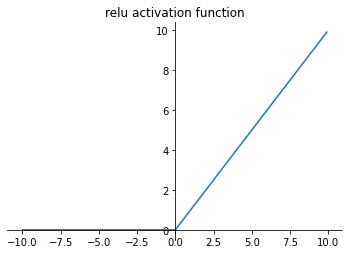

In [33]:
def relu(x): 
    return np.maximum(0,x)

visualize(relu)

### 2.Leaky ReLU 

Leaky ReLU is a modified version of ReLU. It has a small slope for negative values defined by parameter $\alpha$, instead of zero. 

\begin{equation}
  LeakyReLU(x) =
    \begin{cases}
      \alpha x & \text{if } x < 0\\
      x & \text{if } x > 0\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}

[Further Reading on ReLU vs Leaky ReLU](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7)

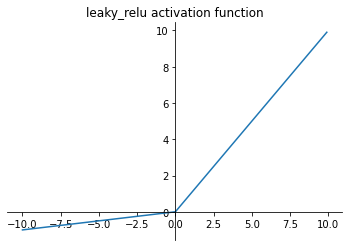

In [34]:
def leaky_relu(x):
  alpha = 0.1
  return np.where(x > 0, x, x * alpha)

visualize(leaky_relu)

### 3.Sigmoid
Sigmoid function output a number between 0 and 1. 
If the input is very negative, the output is approximately 0. If the input is very positive, the output is approximately 1. If the input is 0, the output is 0.5

\begin{equation*}
Sigmoid(x) = \frac{1}{1 + e^{-x}}
\end{equation*}

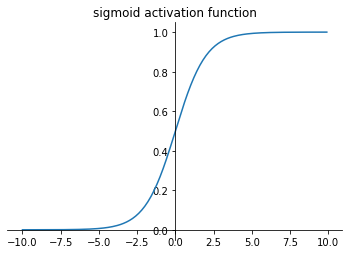

In [35]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))

visualize(sigmoid)

### 4.Tanh

Tanh function is a scaled version of the sigmoid function, it outputs a number between -1 and 1 instead. 
If the input is very negative, the output is approximately -1. If the input is very positive, the output is approximately 1. If the input is 0, the output is 0.

\begin{equation*}
Tanh(x) = \frac{2}{1 + e^{-2x}} -1
\end{equation*}

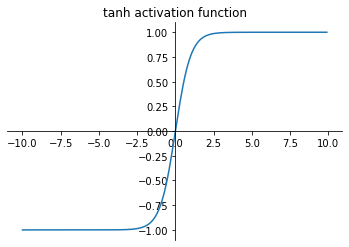

In [37]:
def tanh(x): 
    return np.tanh(x)

visualize(tanh)

## Initialization

We will be initializing our weights using the Xavier Initialization:
\begin{equation*}
W \sim \mathcal{N}(\mu = 0,\,\sigma^{2} = \frac{1}{\text{previous layer size}})\,.
\end{equation*}

[Further Reading on Weight Initialization](https://www.deeplearning.ai/ai-notes/initialization/)

In [23]:
# Initialize our Multilayer Perceptron
class MLP(object):
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        # np.random.normal takes the standard deviation as input, so we take the square root of layer size
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_size**-0.5, 
                                       (self.input_size, self.hidden_size))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_size**-0.5, 
                                       (self.hidden_size, self.output_size))
        
        # Initialize learning rate (see later section)
        self.learning_rate = learning_rate
        
        # Sigmoid activation function
        self.activation_function = sigmoid

# Back Propagation

# Training Loop

# Hyperparameters Tuning